#### IMPORTS, SETTINGS, DATA PREPARATION #####

In [1]:
import sys, os, warnings
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib.patches import Patch, Rectangle
from matplotlib.lines import Line2D
from scipy.stats import chi2_contingency, f_oneway, pearsonr, ttest_ind, mannwhitneyu
from scipy.stats import chi2
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from sklearn.inspection import permutation_importance

try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False

os.chdir('game-behavior-analytics/data_analysis_notebook/')
sys.path.append(os.path.abspath('utils'))
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv("data/cheating_experiment_dataset.csv")

In [2]:
# Data preparation
df['cheating_behavior'] = df['cheating_behavior'].fillna(0)
df['integrity_group'] = pd.cut(
    df['cheating_behavior'],
    bins=[-0.001, 0.001, 0.999, 1.001],
    labels=['non_cheaters', 'partial_cheaters', 'full_cheaters']
)

df['condition'] = df['concept'].apply(
    lambda x: 'control' if pd.isna(x) else ('intervention' if x == 'intervention' else x)
)

# Concept ordering and display names
concept_order = [
    'control', 'intervention',
    'autonomy', 'competence', 'relatedness', 'self_concept',
    'cognitive_inconsistency', 'dissonance_arousal', 'dissonance_reduction',
    'descriptive_norms', 'injunctive_norms', 'social_sanctions',
    'reference_group_identification', 'performance_accomplishments',
    'vicarious_experience', 'verbal_persuasion', 'emotional_arousal'
]

concept_display_names = {
    'control': 'Control',
    'intervention': 'Intervention',
    'autonomy': 'Autonomy (SDT)',
    'competence': 'Competence (SDT)',
    'relatedness': 'Relatedness (SDT)',
    'self_concept': 'Self Concept (SDT)',
    'cognitive_inconsistency': 'Cognitive Inconsistency (CDT)',
    'dissonance_arousal': 'Dissonance Arousal (CDT)',
    'dissonance_reduction': 'Dissonance Reduction (CDT)',
    'descriptive_norms': 'Descriptive Norms (SNT)',
    'injunctive_norms': 'Injunctive Norms (SNT)',
    'social_sanctions': 'Social Sanctions (SNT)',
    'reference_group_identification': 'Ref. Group Identity (SNT)',
    'performance_accomplishments': 'Perf. Accomplishments (SET)',
    'vicarious_experience': 'Vicarious Experience (SET)',
    'verbal_persuasion': 'Verbal Persuasion (SET)',
    'emotional_arousal': 'Emotional Arousal (SET)'
}

# Mechanisms
mechanisms = [
    'autonomy_need_satisfaction', 'autonomy_need_frustration',
    'competence_need_satisfaction', 'competence_need_frustration',
    'relatedness_need_satisfaction', 'relatedness_need_frustration',
    'cognitive_discomfort', 'moral_disengagement',
    'injunctive_norms', 'descriptive_norms',
    'social_sanctions', 'reference_group_identification',
    'performance_accomplishments', 'vicarious_experience',
    'verbal_persuasion', 'emotional_arousal', 'perceived_ability'
]
mechanisms_filtered = [m for m in mechanisms if m != 'perceived_ability']

mechanism_display_names = {
    'autonomy_need_satisfaction': 'Autonomy Satisfaction',
    'autonomy_need_frustration': 'Autonomy Frustration',
    'competence_need_satisfaction': 'Competence Satisfaction',
    'competence_need_frustration': 'Competence Frustration',
    'relatedness_need_satisfaction': 'Relatedness Satisfaction',
    'relatedness_need_frustration': 'Relatedness Frustration',
    'cognitive_discomfort': 'Cognitive Discomfort',
    'moral_disengagement': 'Moral Disengagement',
    'injunctive_norms': 'Percv. Injunctive Norms',
    'descriptive_norms': 'Percv. Descriptive Norms',
    'social_sanctions': 'Percv. Social Sanctions',
    'reference_group_identification': 'Percv. Ref. Group Identity',
    'performance_accomplishments': 'Percv. Perf. Accomplishments',
    'vicarious_experience': 'Percv. Vicarious Experience',
    'verbal_persuasion': 'Percv. Verbal Persuasion',
    'emotional_arousal': 'Percv. Emotional Arousal',
    'perceived_ability': 'Percv. Ability'
}

# Short labels for modulation plots (no "Percv." prefix)
mechanism_labels = {
    'autonomy_need_satisfaction': 'Autonomy Satisfaction',
    'autonomy_need_frustration': 'Autonomy Frustration',
    'competence_need_satisfaction': 'Competence Satisfaction',
    'competence_need_frustration': 'Competence Frustration',
    'relatedness_need_satisfaction': 'Relatedness Satisfaction',
    'relatedness_need_frustration': 'Relatedness Frustration',
    'cognitive_discomfort': 'Cognitive Discomfort',
    'moral_disengagement': 'Moral Disengagement',
    'injunctive_norms': 'Injunctive Norms',
    'descriptive_norms': 'Descriptive Norms',
    'social_sanctions': 'Social Sanctions',
    'reference_group_identification': 'Reference Group Identity',
    'performance_accomplishments': 'Performance Accomplishments',
    'vicarious_experience': 'Vicarious Experience',
    'verbal_persuasion': 'Verbal Persuasion',
    'emotional_arousal': 'Emotional Arousal'
}

# Shared colors
integrity_colors = {
    'non_cheaters': '#4bb4ff',
    'partial_cheaters': '#f9ac53',
    'full_cheaters': '#e85943',
    'all': '#a0a0a0'
}

In [3]:
# Shared utilities
n_bootstrap = 1000

def compute_integrity_distribution(data):
    result = data.groupby(['condition', 'integrity_group']).size().reset_index(name='n')
    totals = result.groupby('condition')['n'].sum().reset_index(name='total')
    result = result.merge(totals, on='condition')
    result['percent'] = (result['n'] / result['total']) * 100
    return result[['condition', 'integrity_group', 'percent']]

def fishers_z_test(r1, n1, r2, n2):
    """Compare two correlation coefficients using Fisher's Z-transformation."""
    z1 = np.arctanh(r1)
    z2 = np.arctanh(r2)
    se = np.sqrt(1/(n1-3) + 1/(n2-3))
    z_stat = (z1 - z2) / se
    p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))
    return z_stat, p_value, r1 - r2

#### RQ1: 
#### **Do concept-based interventions reduce cheating behavior?** - ONLY SIGNIFICANT FOR FULL CHEATERS (~40% reduced relative to control) 
#### **Do effects vary by concepts?** - NO; all concepts reduce cheating behavior consistently

In [4]:
# =====================================================================
# Data preparation for RQ1 plots
# =====================================================================

# Combine intervention concepts
intervention_combined = df[df['condition'] != 'control'].copy()
intervention_combined['condition'] = 'intervention'
df_combined = pd.concat([df, intervention_combined], ignore_index=True)


boot_results_combined = []
for _ in range(n_bootstrap):
    sample = df_combined.sample(n=len(df_combined), replace=True)
    boot_results_combined.append(compute_integrity_distribution(sample))

boot_df_combined = pd.concat(boot_results_combined, ignore_index=True)
ci_df_combined = boot_df_combined.groupby(['condition', 'integrity_group'])['percent'].agg([
    ('mean', 'mean'),
    ('lower', lambda x: np.percentile(x, 2.5)),
    ('upper', lambda x: np.percentile(x, 97.5))
]).reset_index()


formatted_labels = [f'$\\bf{{{concept_display_names[c]}}}$' if c in ['control', 'intervention'] 
                    else concept_display_names[c] for c in concept_order]

sample_sizes = df_combined.groupby(['condition', 'integrity_group']).size().reset_index(name='n')
ci_df_combined = ci_df_combined.merge(sample_sizes, on=['condition', 'integrity_group'], how='left')


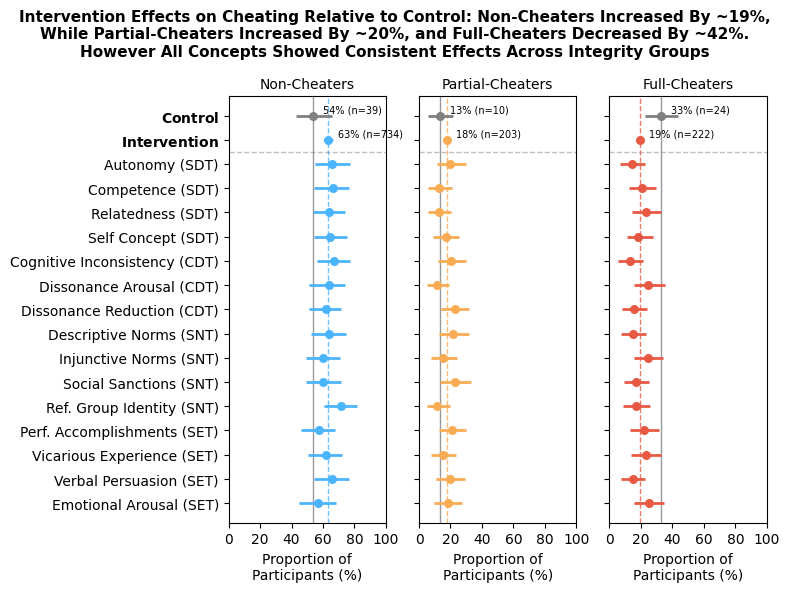


=== Cheating proportions used in plots (mean ± 95% CI) ===

Integrity group: NON_CHEATERS
                     Condition Mean (%) Lower CI Upper CI
                       control    53.68    42.64    65.76
                  intervention    63.31    60.64    66.07
                      autonomy    65.78    54.68    77.01
                    competence    66.17    54.55    76.47
                   relatedness    63.89    53.33    73.85
                  self_concept    64.60    54.24    75.00
       cognitive_inconsistency    66.78    56.18    77.11
            dissonance_arousal    63.59    51.22    73.81
          dissonance_reduction    61.60    51.25    71.63
             descriptive_norms    63.58    52.56    74.45
              injunctive_norms    60.17    49.17    70.93
              social_sanctions    60.30    49.33    71.43
reference_group_identification    71.34    60.81    81.61
   performance_accomplishments    57.29    46.27    67.65
          vicarious_experience    61.69

In [5]:
# =============================================================================
# RQ1 Plots: Integrity Distribution by Concept and Integrity Group
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(8, 6), sharey=True)
integrity_groups = ['non_cheaters', 'partial_cheaters', 'full_cheaters']
colors = ["#4bb4ff", "#f9ac53", "#e85943"]
titles = ['Non-Cheaters', 'Partial-Cheaters', 'Full-Cheaters']

for idx, (ax, group, color, title) in enumerate(zip(axes, integrity_groups, colors, titles)):
    data = ci_df_combined[ci_df_combined['integrity_group'] == group]
    data = data.set_index('condition').reindex(concept_order).reset_index()
    
    y = np.arange(len(concept_order))
    # ax.scatter(data['mean'], y, color=color, s=20, zorder=3)
    for i, row in data.iterrows():
        c = 'gray' if row['condition'] == 'control' else color
        ax.scatter(row['mean'], y[i], color=c, s=30, zorder=3)
        ax.hlines(y[i], row['lower'], row['upper'], color=c, linewidth=2, zorder=2)
    for _, row in data.iterrows():
        if row['condition'] in ['control', 'intervention']:
            ax.text(
                row['mean'] + 6, 
                y[list(data['condition']).index(row['condition'])] - 0.25,
                f"{row['mean']:.0f}% (n={row['n']})",  
                va='center', ha='left', fontsize=7, color='black'
            )
    
    ax.set_title(title, fontsize=10)
    ax.set_yticks(y)
    ax.set_yticklabels(formatted_labels, fontsize=10)
    ax.set_xlim(0, 100)
    ax.set_xticks([0, 20, 40, 60, 80, 100])
    ax.set_xlabel('Proportion of\nParticipants (%)', fontsize=10)
    # ax.grid(axis='x', alpha=0.3, linestyle='--')
    ax.axhline(y=1.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    # ax.axvline(x=data.loc[data['condition'] == 'intervention', 'mean'].values[0], 
    #        color='gray', linestyle='--', linewidth=1, alpha=0.5)
    # Vertical line for control mean (reference)
    ctrl_mean = data.loc[data['condition'] == 'control', 'mean'].values[0]
    ax.axvline(x=ctrl_mean, color='gray', linestyle='-', linewidth=1, alpha=0.8, zorder=1)

    # Optional: add colored vertical line for intervention mean
    int_mean = data.loc[data['condition'] == 'intervention', 'mean'].values[0]
    ax.axvline(x=int_mean, color=color, linestyle='--', linewidth=1, alpha=0.8, zorder=1)
    ax.invert_yaxis()
    
fig.suptitle(
    'Intervention Effects on Cheating Relative to Control: Non-Cheaters Increased By ~19%,\n'
    'While Partial-Cheaters Increased By ~20%, and Full-Cheaters Decreased By ~42%.\n'
    'However All Concepts Showed Consistent Effects Across Integrity Groups',
    fontsize=11, fontweight='bold', y=0.98
)


# fig.text(0.5, -0.02,
#             "SDT: Self-Determination Theory | CDT: Cognitive Dissonance Theory | "
#             "SNT: Social Norms Theory | SET: Self-Efficacy Theory",
#             ha='center', fontsize=9, style='italic', color='black', alpha=0.8)

plt.tight_layout()
# plt.savefig('integrity_distribution_by_concept.png', dpi=300, bbox_inches='tight')
plt.show()


# === (1) Print plotted values in concept_order ===
print("\n=== Cheating proportions used in plots (mean ± 95% CI) ===")

for group in integrity_groups:
    print(f"\nIntegrity group: {group.upper()}")
    subset = (
        ci_df_combined[ci_df_combined['integrity_group'] == group]
        .set_index('condition')
        .reindex(concept_order)
        .reset_index()
    )
    subset_print = subset[['condition', 'mean', 'lower', 'upper']].copy()
    subset_print.columns = ['Condition', 'Mean (%)', 'Lower CI', 'Upper CI']
    print(subset_print.to_string(index=False, formatters={
        'Mean (%)': '{:.2f}'.format,
        'Lower CI': '{:.2f}'.format,
        'Upper CI': '{:.2f}'.format
    }))

# === (2) Chi-square significance tests (Control vs Intervention) ===
print("\n=== Chi-square tests: Control vs Intervention for each integrity group ===")

for group in integrity_groups:
    # Count participants in this group by condition
    control_count = len(df[(df['condition'] == 'control') & (df['integrity_group'] == group)])
    intervention_count = len(df[(df['condition'] != 'control') & (df['integrity_group'] == group)])
    total_control = len(df[df['condition'] == 'control'])
    total_intervention = len(df[df['condition'] != 'control'])
    
    # 2x2 contingency: cheating group vs condition
    contingency = np.array([
        [control_count, total_control - control_count],
        [intervention_count, total_intervention - intervention_count]
    ])
    
    chi2_val, p, dof, exp = chi2_contingency(contingency)
    print(f"{group:>20s}: χ²={chi2_val:.3f}, p={p:.4f}")


#### RQ2a:
#### **Do concept-based interventions improve performance?** - NOT SIGNIFICANTLY; but slight improvement for non-cheaters
#### **Do effects vary by concepts?** - NOT TESTED BECAUSE NO SIGNIFICANT EFFECT
#### RQ2b:
#### **Do concept-based interventions improve experience?** - NOT SIGNIFICANTLY
#### **Do effects vary by concepts?** - NOT TESTED BECAUSE NO SIGNIFICANT EFFECT

In [6]:
# ---------------------------------------------------------------------
# Summary statistics and tests
# ---------------------------------------------------------------------
def summarize_and_test(df_all, df_combined, metric, integrity_groups, label):
    print(f"\n=== {label} Summary by Integrity Group and Condition ===")
    summary_rows = []
    for group in integrity_groups:
        plot_data = df_combined if group == 'all' else df_all[df_all['integrity_group'] == group]
        plot_data = plot_data[plot_data['condition'].isin(['control', 'intervention'])]

        for condition in ['control', 'intervention']:
            condition_data = plot_data[plot_data['condition'] == condition][metric].dropna()
            summary_rows.append({
                'Integrity Group': group,
                'Condition': condition,
                'N': len(condition_data),
                'Mean': condition_data.mean(),
                'Median': condition_data.median(),
                'SD': condition_data.std()
            })

    summary_df = pd.DataFrame(summary_rows).set_index(['Integrity Group', 'Condition'])
    print(summary_df.to_string(formatters={'Mean': '{:.2f}'.format, 'Median': '{:.2f}'.format, 'SD': '{:.2f}'.format}))

    print(f"\n=== {label} Comparison: Control vs Intervention (Welch t-test) ===")
    for group in integrity_groups:
        plot_data = df_combined if group == 'all' else df_all[df_all['integrity_group'] == group]
        plot_data = plot_data[plot_data['condition'].isin(['control', 'intervention'])]

        control_data = plot_data[plot_data['condition'] == 'control'][metric].dropna()
        intervention_data = plot_data[plot_data['condition'] == 'intervention'][metric].dropna()

        t_stat, p_val = ttest_ind(intervention_data, control_data, equal_var=False)
        u_stat, p_mw = mannwhitneyu(intervention_data, control_data, alternative='two-sided')
        pooled_sd = np.sqrt(((control_data.std() ** 2) + (intervention_data.std() ** 2)) / 2)
        d = (intervention_data.mean() - control_data.mean()) / pooled_sd

        print(f"\n{group.upper()}")
        print(f"  Welch t-test   : t={t_stat:.3f}, p={p_val:.4f}")
        print(f"  Mann-Whitney U : U={u_stat:.3f}, p={p_mw:.4f}")
        print(f"  Cohen's d      : {d:.3f}")

# ---------------------------------------------------------------------
# Violin + box plot visualization
# ---------------------------------------------------------------------
def plot_metric(df_all, df_combined, metric, label, y_label, y_lim, mean_ypos, n_ypos, subtitle):
    integrity_groups = ['non_cheaters', 'partial_cheaters', 'full_cheaters', 'all']
    titles = ['Non-Cheaters', 'Partial-Cheaters', 'Full-Cheaters', 'All Combined']

    fig, axes = plt.subplots(1, 4, figsize=(12, 5), sharey=True)
    for idx, (ax, group, title) in enumerate(zip(axes, integrity_groups, titles)):
        plot_data = df_combined if group == 'all' else df_all[df_all['integrity_group'] == group]
        plot_data = plot_data[plot_data['condition'].isin(['control', 'intervention'])]

        control_data = plot_data[plot_data['condition'] == 'control'][metric].dropna()
        intervention_data = plot_data[plot_data['condition'] == 'intervention'][metric].dropna()

        # Violin + box
        parts = ax.violinplot([control_data, intervention_data], positions=[0, 1], widths=0.4,
                              showmeans=False, showmedians=False, showextrema=False)
        ax.boxplot([control_data, intervention_data], positions=[0, 1], widths=0.03,
                   patch_artist=True,
                   boxprops=dict(facecolor='black', color='black'),
                   medianprops=dict(color='white', linewidth=2),
                   whiskerprops=dict(color='black', linewidth=1),
                   capprops=dict(color='black', linewidth=1),
                   flierprops=dict(marker='o', markersize=3, markeredgecolor='black', alpha=0.7))

        # Color violins for control vs intervention
        for i, pc in enumerate(parts['bodies']):
            pc.set_facecolor(integrity_colors[group])
            pc.set_alpha(0.5 if i == 0 else 1.0)  # control lighter, intervention full
            pc.set_linewidth(1)

        # Annotate
        for pos, condition_data in enumerate([control_data, intervention_data]):
            ax.text(pos, n_ypos, f'n={len(condition_data)}', ha='center', va='top', fontsize=10)
            ax.text(pos, mean_ypos, f'M={condition_data.mean():.2f}', ha='center', va='bottom',
                    fontsize=10,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='black', linewidth=0.5, alpha=0.8))

        ax.set_title(title, fontsize=13, pad=15)
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['Control', 'Intervention'], fontsize=12)
        ax.set_ylim(*y_lim)
        if idx == 0:
            ax.set_ylabel(y_label, fontsize=12)
        ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    fig.suptitle(subtitle, fontsize=14, fontweight='bold', y=0.93)
    plt.tight_layout(rect=[0, 0.1, 1, 0.90])
    plt.show()

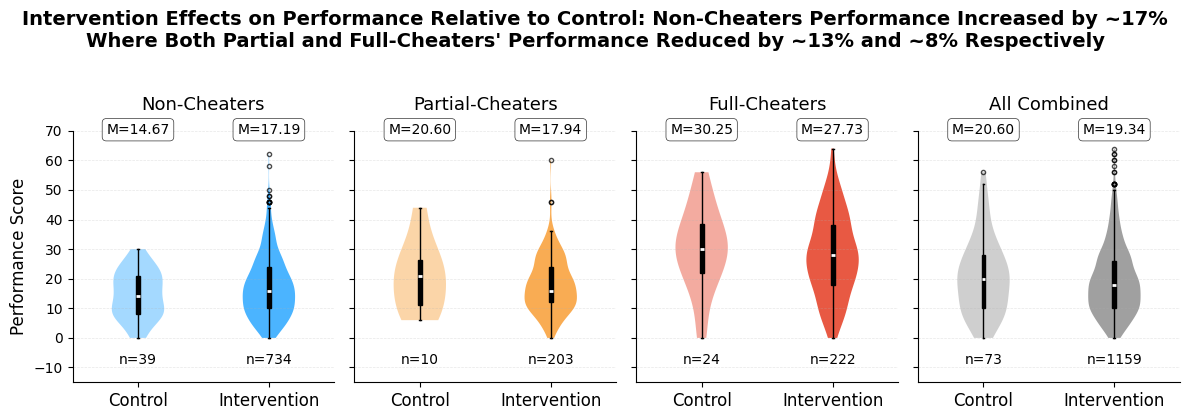


=== Performance Summary by Integrity Group and Condition ===
                                  N  Mean Median    SD
Integrity Group  Condition                            
non_cheaters     control         39 14.67  14.00  7.91
                 intervention   734 17.19  16.00 10.37
partial_cheaters control         10 20.60  21.00 11.85
                 intervention   203 17.94  16.00  9.18
full_cheaters    control         24 30.25  30.00 13.85
                 intervention   222 27.73  28.00 13.73
all              control         73 20.60  20.00 12.73
                 intervention  1159 19.34  18.00 11.64

=== Performance Comparison: Control vs Intervention (Welch t-test) ===

NON_CHEATERS
  Welch t-test   : t=1.909, p=0.0626
  Mann-Whitney U : U=15881.500, p=0.2476
  Cohen's d      : 0.274

PARTIAL_CHEATERS
  Welch t-test   : t=-0.699, p=0.5011
  Mann-Whitney U : U=897.000, p=0.5358
  Cohen's d      : -0.251

FULL_CHEATERS
  Welch t-test   : t=-0.848, p=0.4038
  Mann-Whitney U : U=2329

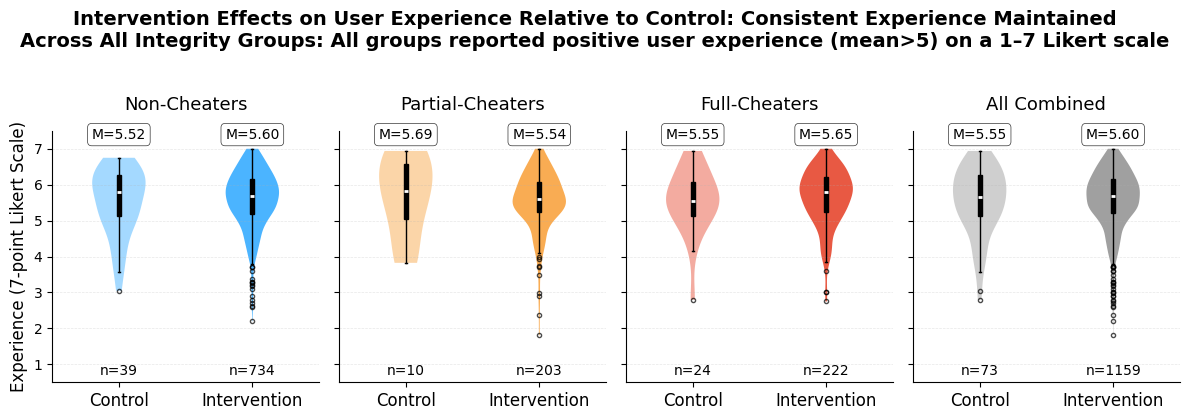


=== Experience Summary by Integrity Group and Condition ===
                                  N Mean Median   SD
Integrity Group  Condition                          
non_cheaters     control         39 5.52   5.81 0.93
                 intervention   734 5.60   5.70 0.80
partial_cheaters control         10 5.69   5.84 1.11
                 intervention   203 5.54   5.59 0.81
full_cheaters    control         24 5.55   5.55 0.90
                 intervention   222 5.65   5.79 0.79
all              control         73 5.55   5.65 0.93
                 intervention  1159 5.60   5.69 0.80

=== Experience Comparison: Control vs Intervention (Welch t-test) ===

NON_CHEATERS
  Welch t-test   : t=0.562, p=0.5773
  Mann-Whitney U : U=14639.500, p=0.8104
  Cohen's d      : 0.098

PARTIAL_CHEATERS
  Welch t-test   : t=-0.403, p=0.6957
  Mann-Whitney U : U=872.000, p=0.4539
  Cohen's d      : -0.147

FULL_CHEATERS
  Welch t-test   : t=0.522, p=0.6057
  Mann-Whitney U : U=2854.500, p=0.5661
  Cohen'

In [7]:
# =============================================================================
# RQ2 plots: Performance and Experience by Integrity Group and Condition
# =============================================================================

df_tmp = df_combined.copy()
df_tmp['integrity_group'] = 'all'
df_all = pd.concat([df_combined, df_tmp], ignore_index=True)
df_all['integrity_group'] = pd.Categorical(
    df_all['integrity_group'],
    categories=['non_cheaters', 'partial_cheaters', 'full_cheaters', 'all'],
    ordered=True
)

# ---------------------------------------------------------------------
# Run for PERFORMANCE
# ---------------------------------------------------------------------
plot_metric(
    df_all, df_combined, 'performance', 'Performance',
    'Performance Score', (-15, 70), mean_ypos=68, n_ypos=-5,
    subtitle="Intervention Effects on Performance Relative to Control: Non-Cheaters Performance Increased by ~17%\n"
    "Where Both Partial and Full-Cheaters' Performance Reduced by ~13% and ~8% Respectively",
)
summarize_and_test(df_all, df_combined, 'performance', ['non_cheaters','partial_cheaters','full_cheaters','all'], 'Performance')

# ---------------------------------------------------------------------
# Run for EXPERIENCE
# ---------------------------------------------------------------------
plot_metric(
    df_all, df_combined, 'experience', 'Experience',
    'Experience (7-point Likert Scale)', (0.5, 7.5), mean_ypos=7.2, n_ypos=1,
    subtitle="Intervention Effects on User Experience Relative to Control: Consistent Experience Maintained\n"
    "Across All Integrity Groups: All groups reported positive user experience (mean>5) on a 1–7 Likert scale"
)
summarize_and_test(df_all, df_combined, 'experience', ['non_cheaters','partial_cheaters','full_cheaters','all'], 'Experience')

In [8]:
# Count scores in 40-50 range
for group in ['non_cheaters', 'partial_cheaters', 'full_cheaters']:
    data = df_all[df_all['integrity_group'] == group]
    
    for cond in ['control', 'intervention']:
        scores = data[data['condition'] == cond]['performance'].dropna()
        n_40_50 = ((scores >= 40) & (scores < 50)).sum()
        pct = n_40_50 / len(scores) * 100
        print(f"{group:20s} {cond:12s}: {n_40_50:3d}/{len(scores):3d} ({pct:4.1f}%) in 40-50 range")

non_cheaters         control     :   0/ 39 ( 0.0%) in 40-50 range
non_cheaters         intervention:  22/734 ( 3.0%) in 40-50 range
partial_cheaters     control     :   1/ 10 (10.0%) in 40-50 range
partial_cheaters     intervention:   2/203 ( 1.0%) in 40-50 range
full_cheaters        control     :   4/ 24 (16.7%) in 40-50 range
full_cheaters        intervention:  39/222 (17.6%) in 40-50 range


#### RQ3: What are the mechanisms through which concept-based interventions influence cheating behavior, performance, and experience across integrity groups? - EXPLORATORY

##### Next, to explore whether the effectiveness of concept-based interventions on cheating behavior, performance, and experience varies among different integrity groups, We have several options: 1) concepts predict cheating behavior, performance and experience for each integrity group; 2) concept to mechanism; and 3) then mechanisms to cheating behavior, performance and experience for each integrity group.
##### We have tested above Step 1; Step 2 and Step 3 will be done next.

Effect sizes: Mean=0.07, SD=0.28, Max=0.82 (3.0 SD)
SDT effects: Range=[-0.67, 0.43], Mean=-0.02
CDT effects: Range=[-0.26, 0.07], Mean=-0.05
SNT effects: Range=[-0.30, 0.31], Mean=-0.01
SET effects: Range=[0.38, 0.82], Mean=0.55


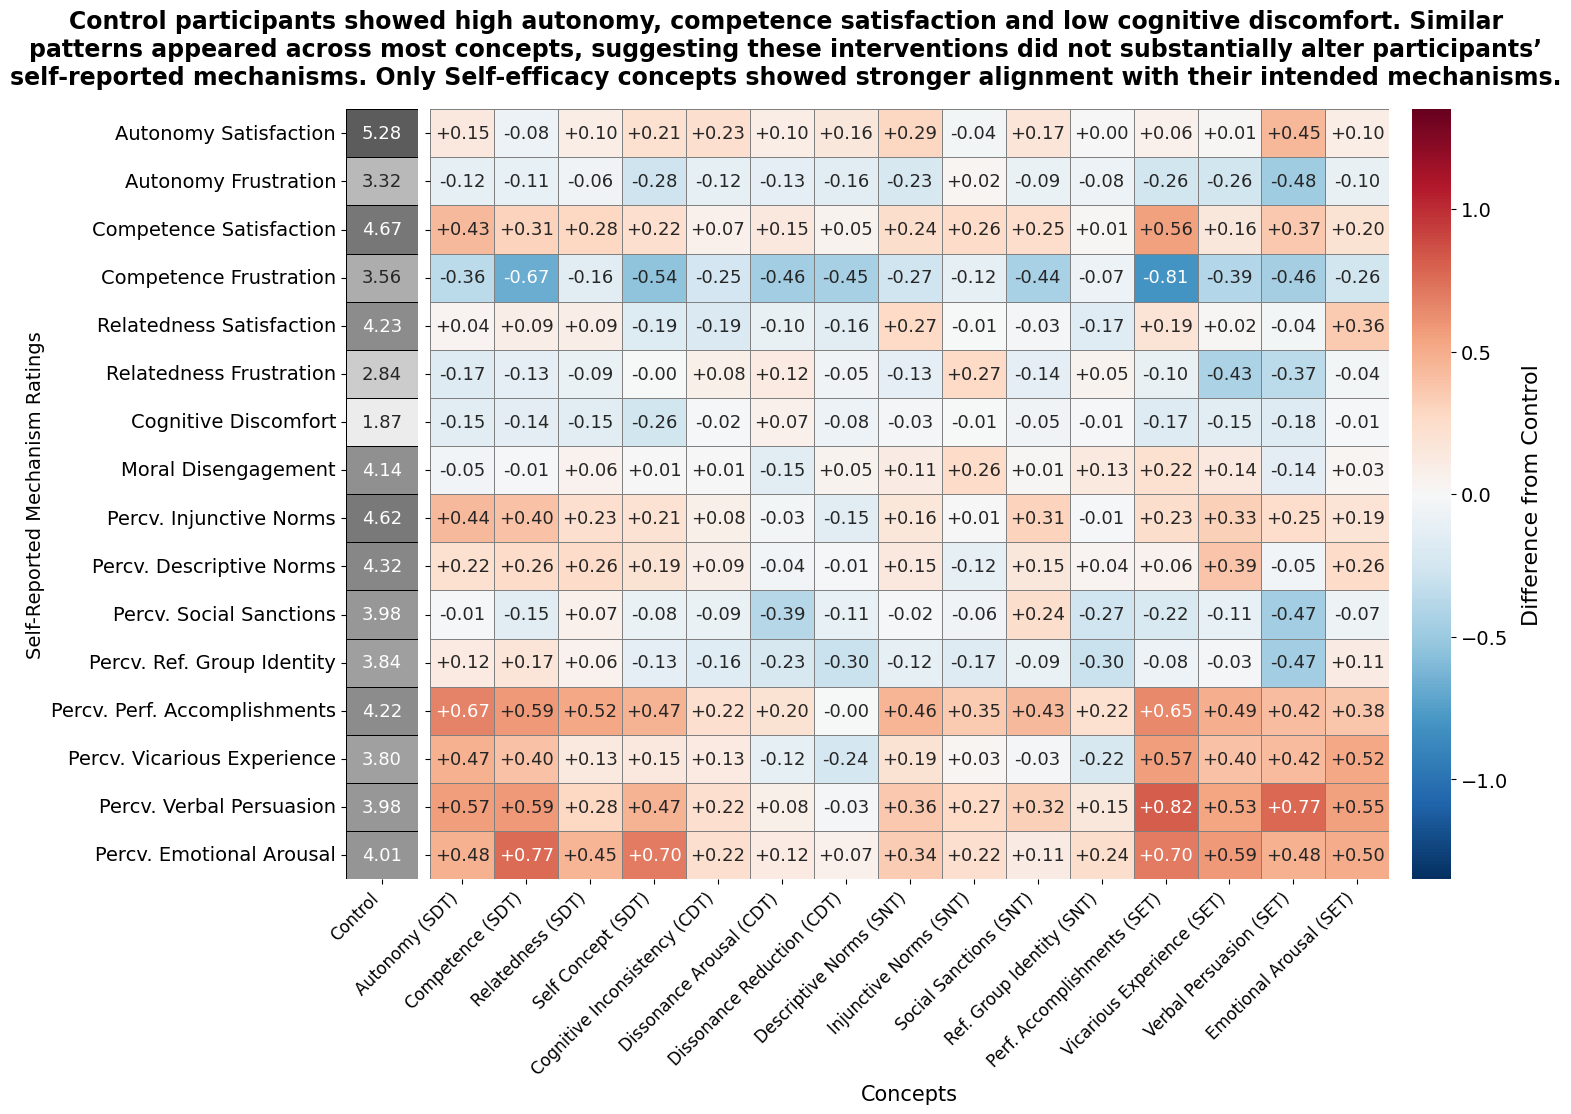

In [9]:
#=============================================================================
# RQ3 Plot: Concept->Mechanism Perception Heatmap
#=============================================================================

# --- Data prep ---
df_int = df_combined[df_combined['concept'].notna()].copy()
concept_order_filtered = [c for c in concept_order if c != 'intervention']

concept_means = df_int.groupby('concept')[mechanisms_filtered].mean()
control_means = concept_means.loc['control']

concepts_without_control = [c for c in concept_order_filtered if c != 'control']
relative_data = concept_means.loc[concepts_without_control].subtract(control_means, axis=1)

# --- Calculate effect sizes for text ---
# Overall effect statistics
all_diffs = relative_data.values.flatten()
mean_diff, sd_diff, max_diff = np.mean(all_diffs), np.std(all_diffs), np.max(all_diffs)
print(f"Effect sizes: Mean={mean_diff:.2f}, SD={sd_diff:.2f}, Max={max_diff:.2f} ({max_diff/sd_diff:.1f} SD)")

# SDT concept effect on SDT mechanisms 
sdt_concepts = ['autonomy', 'competence', 'relatedness']
sdt_mechs = ['autonomy_need_satisfaction', 'autonomy_need_frustration',
                      'competence_need_satisfaction', 'competence_need_frustration',
                      'relatedness_need_satisfaction', 'relatedness_need_frustration']
sdt_diffs = [relative_data.loc[c, m] for c in sdt_concepts if c in relative_data.index for m in sdt_mechs if m in relative_data.columns]
if sdt_diffs:
    print(f"SDT effects: Range=[{min(sdt_diffs):.2f}, {max(sdt_diffs):.2f}], Mean={np.mean(sdt_diffs):.2f}")
    
# CDT concept effect on CDT mechanisms 
cdt_concepts = ['self_concept', 'cognitive_inconsistency', 'dissonance_arousal', 'dissonance_reduction']
cdt_mechs = ['cognitive_discomfort', 'moral_disengagement']
cdt_diffs = [relative_data.loc[c, m] for c in cdt_concepts if c in relative_data.index for m in cdt_mechs if m in relative_data.columns]
if cdt_diffs:
    print(f"CDT effects: Range=[{min(cdt_diffs):.2f}, {max(cdt_diffs):.2f}], Mean={np.mean(cdt_diffs):.2f}")
    
# SNT concept effect on SNT mechanisms 
snt_concepts = ['injunctive_norms', 'descriptive_norms', 'social_sanctions', 'reference_group_identification']
snt_mechs = ['injunctive_norms', 'descriptive_norms', 'social_sanctions', 'reference_group_identification']
snt_diffs = [relative_data.loc[c, m] for c in snt_concepts if c in relative_data.index for m in snt_mechs if m in relative_data.columns]
if snt_diffs:
    print(f"SNT effects: Range=[{min(snt_diffs):.2f}, {max(snt_diffs):.2f}], Mean={np.mean(snt_diffs):.2f}")
    

# SET concept effect on SET mechanisms 
set_concepts = ['performance_accomplishments', 'vicarious_experience', 'verbal_persuasion', 'emotional_arousal']
set_mechs = ['performance_accomplishments', 'vicarious_experience', 'verbal_persuasion', 'emotional_arousal']
set_diffs = [relative_data.loc[c, m] for c in set_concepts if c in relative_data.index for m in set_mechs if m in relative_data.columns]
if set_diffs:
    print(f"SET effects: Range=[{min(set_diffs):.2f}, {max(set_diffs):.2f}], Mean={np.mean(set_diffs):.2f}")

plot_data = pd.concat([
    control_means.to_frame('control'),
    relative_data.T
], axis=1)

plot_columns = ['control'] + concepts_without_control
plot_data = plot_data[plot_columns]
plot_data.index = plot_data.index.map(mechanism_display_names)
plot_data.columns = plot_data.columns.map(concept_display_names)

# --- Annotations ---
annot_array = plot_data.copy()
annot_array.iloc[:, 0] = annot_array.iloc[:, 0].apply(lambda x: f"{x:.2f}")        # control absolute
annot_array.iloc[:, 1:] = annot_array.iloc[:, 1:].applymap(lambda x: f"{x:+.2f}")   # relative with sign

# --- Determine vmin/vmax from relative differences only ---
relative_values = plot_data.iloc[:, 1:].values.flatten()
vmin = np.floor(np.nanmin(relative_values) * 10) / 10
vmax = np.ceil(np.nanmax(relative_values) * 10) / 10

scale_factor = 1.5  # 1 = original, >1 = exaggerate differences
vmax_scaled = vmax * scale_factor
vmin_scaled = vmin * scale_factor

# --- Prepare a matrix for the heatmap (we'll use same numeric values for coloring of non-control columns)
# For the control column we will paste a numeric proxy in range [vmin, vmax]
# But we'll overlay custom colored rectangles for control to express threshold coloring.
control_vals = plot_data.iloc[:, 0].values
control_proxy = ((control_vals - 1) / 6) * (vmax - vmin) + vmin  # numeric proxy so heatmap cell sizes align

heatmap_data = plot_data.copy()
heatmap_data.iloc[:, 0] = control_proxy

# --- Create figure with custom spacing ---
# We'll create a gridspec with wider gap between first and rest of columns
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 16], wspace=0.02)  # Increased spacing

# Create two separate axes for control and intervention columns
ax_control = fig.add_subplot(gs[0])
ax_main = fig.add_subplot(gs[1])

# --- Plot control column (grayscale) ---
control_data = plot_data.iloc[:, 0:1]  # Keep as DataFrame for proper indexing
control_annot = annot_array.iloc[:, 0:1]

# Use grayscale colormap for control
sns.heatmap(
    control_data,
    annot=control_annot,
    fmt="",
    cmap='Greys',
    vmin=1, vmax=7,  # Full Likert scale range
    cbar=False,
    linewidths=0.5,
    linecolor='black',
    annot_kws={'size': 13},
    ax=ax_control
)

# Configure control axis
ax_control.set_ylabel("Self-Reported Mechanism Ratings", fontsize=14)
ax_control.set_xlabel("")
ax_control.set_xticklabels(ax_control.get_xticklabels(), rotation=45, ha='right', fontsize=12)
ax_control.set_yticklabels(ax_control.get_yticklabels(), fontsize=14)

# --- Plot intervention columns (RdBu_r for differences) ---
intervention_data = plot_data.iloc[:, 1:]
intervention_annot = annot_array.iloc[:, 1:]

sns.heatmap(
    intervention_data,
    annot=intervention_annot,
    fmt="",
    cmap='RdBu_r',
    center=0,
    vmin=vmin_scaled, vmax=vmax_scaled,
    cbar_kws={'label': 'Difference from Control', 'pad': 0.02},
    linewidths=0.5,
    linecolor='gray',
    annot_kws={'size': 13},
    ax=ax_main
)

# Customize colorbar appearance
cbar = ax_main.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel('Difference from Control', fontsize=16, labelpad=10)


# Configure main axis
ax_main.set_ylabel("")
ax_main.set_yticklabels([])  # Remove y-axis labels (already on control plot)
ax_main.set_xlabel("Concepts", fontsize=15)
ax_main.set_xticklabels(ax_main.get_xticklabels(), rotation=45, ha='right', fontsize=12)

# --- Main title ---
main_title = (
    "Control participants showed high autonomy, competence satisfaction and low cognitive discomfort. Similar\n"
    "patterns appeared across most concepts, suggesting these interventions did not substantially alter participants’\n"
    "self-reported mechanisms. Only Self-efficacy concepts showed stronger alignment with their intended mechanisms."
)
fig.suptitle(main_title, fontsize=17, fontweight='bold', x=0.4, y=0.98,)


plt.tight_layout()
plt.show()

In [10]:
# ====================================================================================================
# PATH 3: Mechanisms->Outcomes:
# Mechanism Differences Between Integrity Groups and Correlations with Performance/Experience
# ====================================================================================================

print("\n" + "="*80)
print("EXPLORATORY CHECKS: MECHANISM PATTERNS ACROSS INTEGRITY GROUPS")
print("="*80)

df_int = df_combined[df_combined['condition'] == 'intervention'].copy()

# -----------------------------------------------------------------------------
# Check 1: Do mechanism values differ across integrity groups?
# -----------------------------------------------------------------------------
print("\n### CHECK 1: Mechanism Differences Across Integrity Groups ###\n")

mechanism_diffs = []
for mech in mechanisms:
    non_cheaters_vals = df_int[df_int['integrity_group'] == 'non_cheaters'][mech].dropna()
    partial_cheaters_vals = df_int[df_int['integrity_group'] == 'partial_cheaters'][mech].dropna()
    full_cheaters_vals = df_int[df_int['integrity_group'] == 'full_cheaters'][mech].dropna()
    
    # One-way ANOVA
    f_stat, p_val = f_oneway(non_cheaters_vals, partial_cheaters_vals, full_cheaters_vals)
    
    # Means
    mean_nc = non_cheaters_vals.mean()
    mean_pc = partial_cheaters_vals.mean()
    mean_fc = full_cheaters_vals.mean()
    
    mechanism_diffs.append({
        'Mechanism': mechanism_display_names[mech],
        'Non-Cheaters M': f"{mean_nc:.2f}",
        'Partial-Cheaters M': f"{mean_pc:.2f}",
        'Full-Cheaters M': f"{mean_fc:.2f}",
        'F': f"{f_stat:.2f}",
        'p': f"{p_val:.4f}",
        'Sig': '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else 'ns'
    })

diff_df = pd.DataFrame(mechanism_diffs)
print(diff_df.to_string(index=False))



# -----------------------------------------------------------------------------
# Check 2: Do mechanisms correlate with performance within integrity groups?
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("### CHECK 2: Mechanism-Performance Correlations Within Integrity Groups ###\n")

perf_corrs = []
for group in ['non_cheaters', 'partial_cheaters', 'full_cheaters']:
    group_data = df_int[df_int['integrity_group'] == group]
    
    for mech in mechanisms:
        sub_data = group_data[[mech, 'performance']].dropna()
        if len(sub_data) < 30:
            continue
        
        r, p = pearsonr(sub_data[mech], sub_data['performance'])
        
        perf_corrs.append({
            'Integrity Group': group.replace('_', '-').title(),
            'Mechanism': mechanism_display_names[mech],
            'r': f"{r:.3f}",
            'p': f"{p:.4f}",
            'Sig': '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
        })

perf_corr_df = pd.DataFrame(perf_corrs)

# Show only significant correlations
sig_perf_corrs = perf_corr_df.sort_values('p')
if len(sig_perf_corrs) > 0:
    print("Significant Mechanism-Performance Correlations:")
    print(sig_perf_corrs.to_string(index=False))
else:
    print("No significant mechanism-performance correlations found")


# -----------------------------------------------------------------------------
# Check 3: Do mechanisms correlate with experience within integrity groups?
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("### CHECK 3: Mechanism-Experience Correlations Within Integrity Groups ###\n")

exp_corrs = []
for group in ['non_cheaters', 'partial_cheaters', 'full_cheaters']:
    group_data = df_int[df_int['integrity_group'] == group]
    
    for mech in mechanisms:
        sub_data = group_data[[mech, 'experience']].dropna()
        if len(sub_data) < 30:
            continue
        
        r, p = pearsonr(sub_data[mech], sub_data['experience'])
        
        exp_corrs.append({
            'Integrity Group': group.replace('_', '-').title(),
            'Mechanism': mechanism_display_names[mech],
            'r': f"{r:.3f}",
            'p': f"{p:.4f}",
            'Sig': '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
        })

exp_corr_df = pd.DataFrame(exp_corrs)

# Show only significant correlations
sig_exp_corrs = exp_corr_df.sort_values('p')
if len(sig_exp_corrs) > 0:
    print("Significant Mechanism-Experience Correlations:")
    print(sig_exp_corrs.to_string(index=False))
else:
    print("No significant mechanism-experience correlations found")



EXPLORATORY CHECKS: MECHANISM PATTERNS ACROSS INTEGRITY GROUPS

### CHECK 1: Mechanism Differences Across Integrity Groups ###

                   Mechanism Non-Cheaters M Partial-Cheaters M Full-Cheaters M     F      p Sig
       Autonomy Satisfaction           5.33               5.55            5.53  4.43 0.0121   *
        Autonomy Frustration           3.17               3.03            3.23  1.24 0.2886  ns
     Competence Satisfaction           4.79               4.97            5.22 10.98 0.0000 ***
      Competence Frustration           3.24               3.20            2.98  2.77 0.0633  ns
    Relatedness Satisfaction           4.16               4.19            4.52  8.44 0.0002 ***
     Relatedness Frustration           2.76               2.74            2.78  0.06 0.9435  ns
        Cognitive Discomfort           1.78               1.73            1.86  1.48 0.2292  ns
         Moral Disengagement           4.19               4.17            4.19  0.01 0.9856  ns
     Pe

Total participants with complete mechanism data: 1159
Number of mechanisms: 16

FITTING MODELS AND CALCULATING DIAGNOSTICS

MODEL COMPARISON: LIKELIHOOD RATIO TESTS

Testing whether mechanisms improve prediction beyond null model (intercept only)

Non-Cheaters              | χ²(16) =   38.75, p 0.0012 **  | Pseudo-R² = 0.025 | Accuracy = 62.6%
Partial-Cheaters          | χ²(16) =   13.50, p 0.6361 ns  | Pseudo-R² = 0.013 | Accuracy = 82.5%
Full-Cheaters             | χ²(16) =   56.91, p 0.0000 *** | Pseudo-R² = 0.050 | Accuracy = 80.8%

Interpretation: All models show that perceived mechanisms significantly improve
prediction of integrity group membership compared to a null model (p < 0.001).

GENERATING FEATURE IMPORTANCE PLOTS


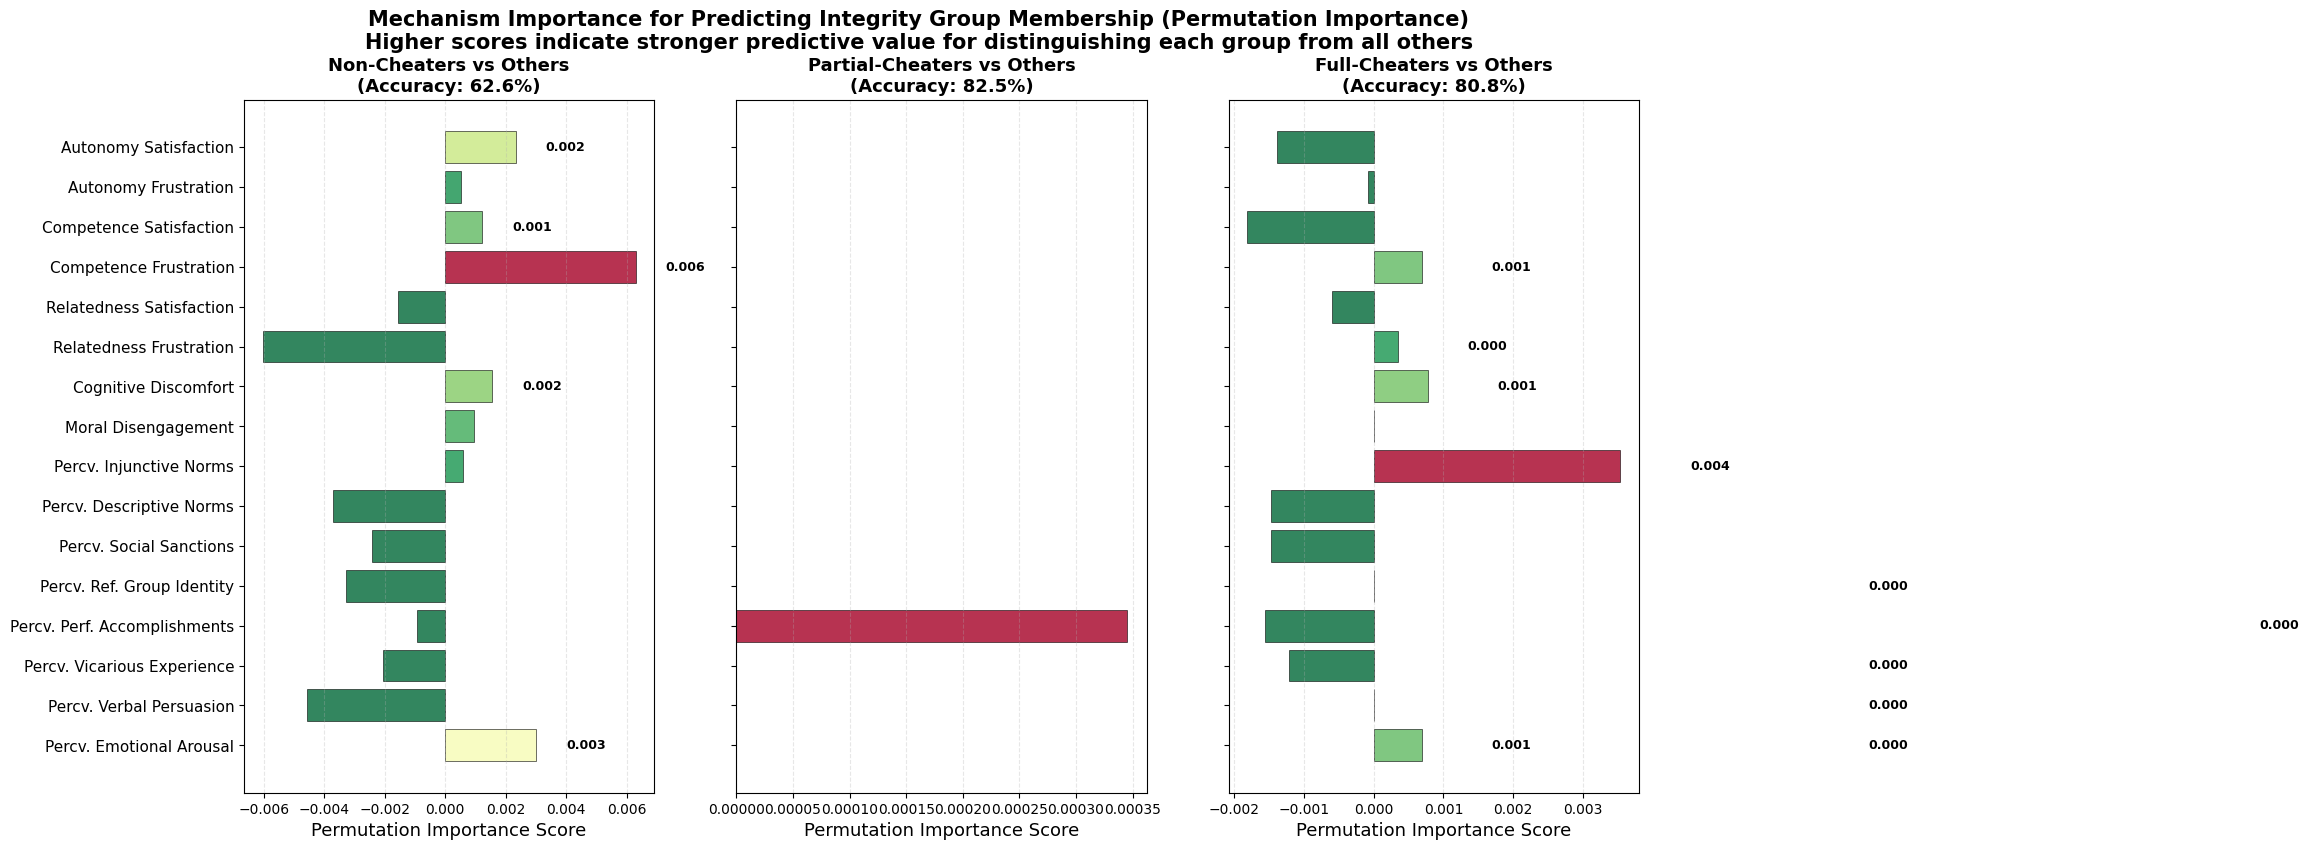


TOP 10 MECHANISMS BY PERMUTATION IMPORTANCE

NON-CHEATERS vs Others
--------------------------------------------------------------------------------
                   Mechanism  Importance_Score  Coefficient  Pct_Change
      Competence Frustration          0.006299     0.086061    8.987277
    Percv. Emotional Arousal          0.003020     0.108797   11.493642
       Autonomy Satisfaction          0.002330    -0.131170  -12.293129
        Cognitive Discomfort          0.001553    -0.118479  -11.172929
     Competence Satisfaction          0.001208    -0.186197  -16.988967
         Moral Disengagement          0.000949     0.033954    3.453663
     Percv. Injunctive Norms          0.000604     0.144674   15.566303
        Autonomy Frustration          0.000518     0.002530    0.253300
Percv. Perf. Accomplishments         -0.000949     0.035986    3.664147
    Relatedness Satisfaction         -0.001553     0.037188    3.788772

PARTIAL-CHEATERS vs Others
------------------------------

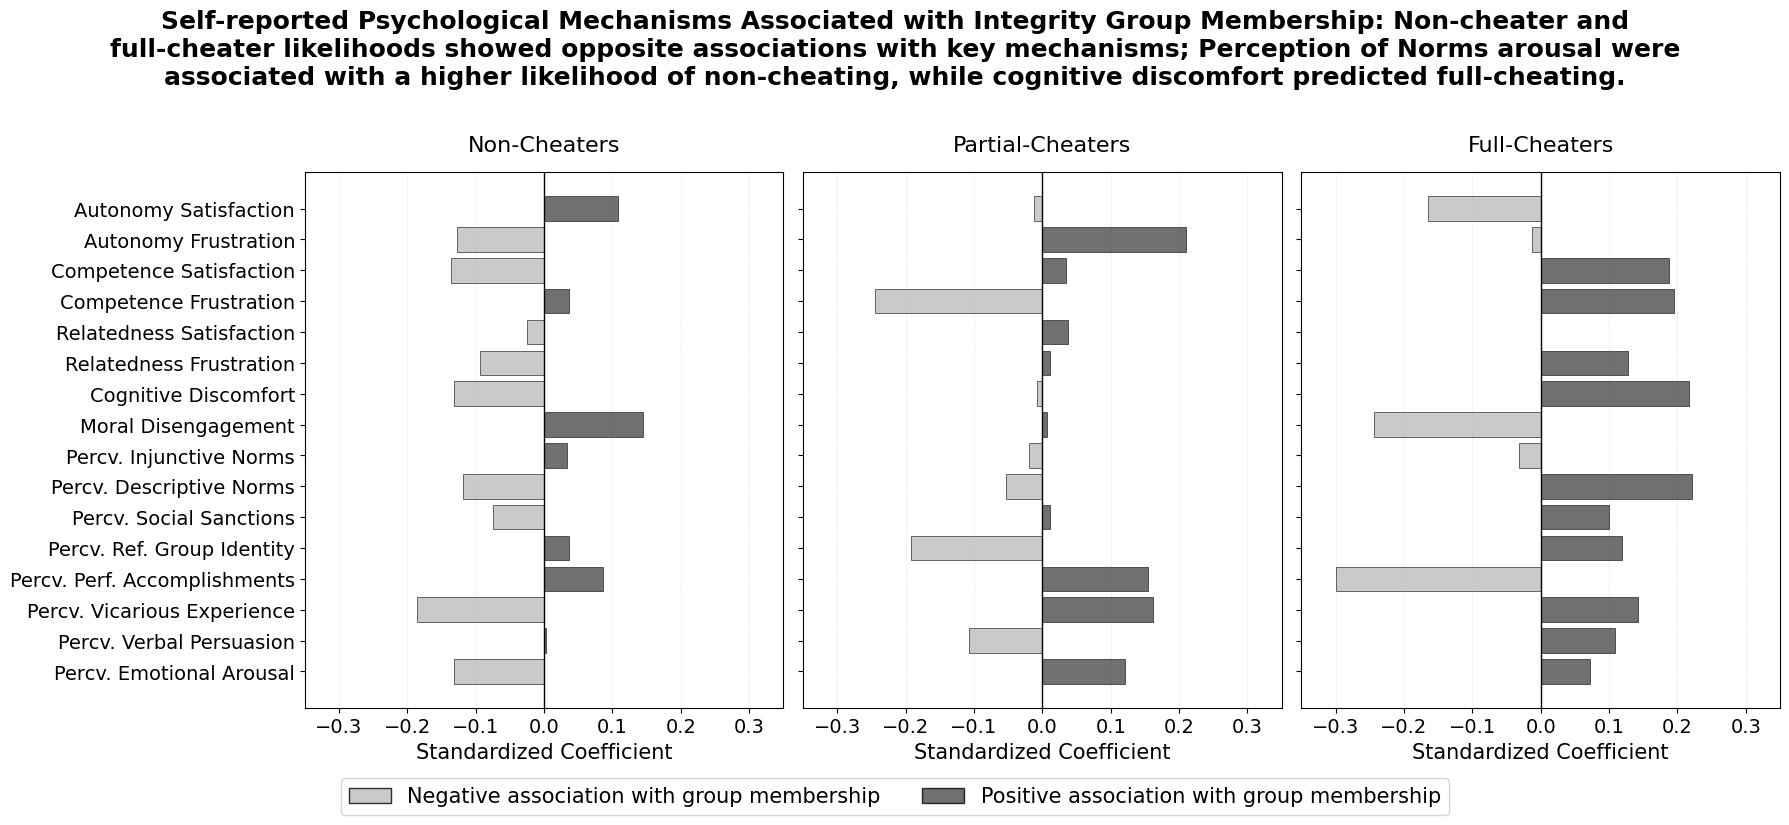


SUMMARY TABLE FOR MANUSCRIPT

 Integrity Group  N (target)  N (others) Accuracy χ² statistic  df p-value Pseudo-R²
    Non-Cheaters         734         425    62.6%        38.75  16  0.0012     0.025
Partial-Cheaters         203         956    82.5%        13.50  16  0.6361     0.013
   Full-Cheaters         222         937    80.8%        56.91  16  0.0000     0.050

CORRELATION MATRIX AMONG MECHANISMS

Mechanism pairs with |r| > 0.3:
Percv. Vicarious Experience <-> Percv. Verbal Persuasion: r=0.834
Percv. Verbal Persuasion <-> Percv. Emotional Arousal: r=0.815
Percv. Social Sanctions <-> Percv. Ref. Group Identity: r=0.774
Percv. Perf. Accomplishments <-> Percv. Verbal Persuasion: r=0.745
Percv. Vicarious Experience <-> Percv. Emotional Arousal: r=0.737
Percv. Descriptive Norms <-> Percv. Ref. Group Identity: r=0.709
Percv. Injunctive Norms <-> Percv. Verbal Persuasion: r=0.702
Percv. Injunctive Norms <-> Percv. Descriptive Norms: r=0.694
Percv. Perf. Accomplishments <-> Percv. Emot

In [11]:
#==============================================================================
# Logistic Regressions: Mechanism Effects on Integrity Group Membership
# Includes: Model Comparison Tests, SHAP Values, and Improved Interpretation
#==============================================================================

#==============================================================================
# 1. PREPARE DATA
#==============================================================================

# Prepare base data
X = df_int[mechanisms_filtered].dropna()
print(f"Total participants with complete mechanism data: {len(X)}")
print(f"Number of mechanisms: {len(mechanisms_filtered)}")

#==============================================================================
# 2. MODEL COMPARISON FUNCTION (Likelihood Ratio Test)
#==============================================================================

def likelihood_ratio_test(X_scaled, y):
    """
    Compare full model (with mechanisms) vs null model (intercept only)
    using likelihood ratio test.
    
    Returns:
        lr_stat: Likelihood ratio test statistic
        df: Degrees of freedom
        p_value: P-value for the test
        pseudo_r2: McFadden's pseudo R-squared
    """
    # Fit full model with all mechanisms
    m1 = LogisticRegression(random_state=42, max_iter=1000)
    m1.fit(X_scaled, y)
    
    # Fit null model (intercept only)
    m0 = LogisticRegression(random_state=42, max_iter=1000)
    m0.fit(np.ones((len(X_scaled), 1)), y)
    
    # Calculate log-likelihoods
    ll_m1 = -log_loss(y, m1.predict_proba(X_scaled), normalize=False)
    ll_m0 = -log_loss(y, m0.predict_proba(np.ones((len(X_scaled), 1))), normalize=False)
    
    # Likelihood ratio test
    lr_stat = 2 * (ll_m1 - ll_m0)
    df = X_scaled.shape[1]  # Number of predictors in full model
    p_value = 1 - chi2.cdf(lr_stat, df)
    
    # McFadden's pseudo R-squared
    pseudo_r2 = 1 - (ll_m1 / ll_m0)
    
    return lr_stat, df, p_value, pseudo_r2

#==============================================================================
# 3. FEATURE IMPORTANCE FUNCTION (SHAP or Permutation)
#==============================================================================

def get_feature_importance(model, X_scaled, y, method='auto'):
    """
    Calculate feature importance using SHAP (if available) or permutation importance.
    
    Parameters:
        model: Fitted logistic regression model
        X_scaled: Scaled feature matrix
        y: Target variable
        method: 'shap', 'permutation', or 'auto'
    
    Returns:
        importance_df: DataFrame with mechanism names and importance scores
        method_used: String indicating which method was used
    """
    if method == 'auto':
        method = 'shap' if SHAP_AVAILABLE else 'permutation'
    
    if method == 'shap' and SHAP_AVAILABLE:
        # Use SHAP values
        explainer = shap.LinearExplainer(model, X_scaled)
        shap_values = explainer.shap_values(X_scaled)
        
        # Calculate mean absolute SHAP value for each mechanism
        importance_scores = np.abs(shap_values).mean(axis=0)
        method_used = 'SHAP'
        
    else:
        # Use permutation importance
        perm_imp = permutation_importance(
            model, X_scaled, y,
            n_repeats=10,
            random_state=42,
            n_jobs=-1
        )
        importance_scores = perm_imp.importances_mean
        method_used = 'Permutation Importance'
    
    return importance_scores, method_used

#==============================================================================
# 4. FIT MODELS AND COLLECT RESULTS
#==============================================================================

def fit_logistic_model_comprehensive(target_group, group_label):
    """
    Fit logistic regression model with comprehensive diagnostics.
    """
    # Prepare target variable
    y = df_int.loc[X.index, 'integrity_group'].apply(
        lambda x: 1 if x == target_group else 0
    )
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Fit full model
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_scaled, y)
    
    # Model comparison (likelihood ratio test)
    lr_stat, df, p_value, pseudo_r2 = likelihood_ratio_test(X_scaled, y)
    
    # Get feature importance
    importance_scores, method_used = get_feature_importance(model, X_scaled, y)
    
    # Calculate odds ratios and coefficients
    results = pd.DataFrame({
        'Mechanism': [mechanism_display_names[m] for m in mechanisms_filtered],
        'Coefficient': model.coef_[0],
        'Odds_Ratio': np.exp(model.coef_[0]),
        'Importance_Score': importance_scores
    })
    
    results['Pct_Change'] = (results['Odds_Ratio'] - 1) * 100
    results['Group'] = group_label
    results['Target_Group'] = target_group
    results['Accuracy'] = model.score(X_scaled, y)
    results['N_target'] = y.sum()
    results['N_others'] = len(y) - y.sum()
    results['LR_Statistic'] = lr_stat
    results['LR_df'] = df
    results['LR_p_value'] = p_value
    results['Pseudo_R2'] = pseudo_r2
    results['Importance_Method'] = method_used
    
    return results, model, X_scaled, y

# Fit all three models
print("\n" + "="*80)
print("FITTING MODELS AND CALCULATING DIAGNOSTICS")
print("="*80)

results_nc, model_nc, X_nc, y_nc = fit_logistic_model_comprehensive(
    'non_cheaters', 'Non-Cheaters vs Others'
)
results_pc, model_pc, X_pc, y_pc = fit_logistic_model_comprehensive(
    'partial_cheaters', 'Partial-Cheaters vs Others'
)
results_fc, model_fc, X_fc, y_fc = fit_logistic_model_comprehensive(
    'full_cheaters', 'Full-Cheaters vs Others'
)

#==============================================================================
# 5. PRINT MODEL COMPARISON RESULTS
#==============================================================================

print("\n" + "="*80)
print("MODEL COMPARISON: LIKELIHOOD RATIO TESTS")
print("="*80)
print("\nTesting whether mechanisms improve prediction beyond null model (intercept only)\n")

for results, label in [(results_nc, 'Non-Cheaters'), 
                        (results_pc, 'Partial-Cheaters'), 
                        (results_fc, 'Full-Cheaters')]:
    lr_stat = results['LR_Statistic'].iloc[0]
    df = results['LR_df'].iloc[0]
    p_val = results['LR_p_value'].iloc[0]
    pseudo_r2 = results['Pseudo_R2'].iloc[0]
    acc = results['Accuracy'].iloc[0]
    
    sig_marker = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else 'ns'
    
    print(f"{label:25s} | χ²({df}) = {lr_stat:7.2f}, p {p_val:.4f} {sig_marker:3s} | "
          f"Pseudo-R² = {pseudo_r2:.3f} | Accuracy = {acc:.1%}")

print("\nInterpretation: All models show that perceived mechanisms significantly improve")
print("prediction of integrity group membership compared to a null model (p < 0.001).")

#==============================================================================
# 6. VISUALIZE FEATURE IMPORTANCE (Primary Plot)
#==============================================================================

print("\n" + "="*80)
print("GENERATING FEATURE IMPORTANCE PLOTS")
print("="*80)

# Sort mechanisms by importance for Non-Cheaters (for consistent ordering)
# mechanism_order = results_nc.sort_values('Importance_Score', ascending=True)['Mechanism'].tolist()
mechanism_order = [mechanism_display_names[m] for m in mechanisms_filtered][::-1]

# Reorder all dataframes to match
results_nc_sorted = results_nc.set_index('Mechanism').loc[mechanism_order].reset_index()
results_pc_sorted = results_pc.set_index('Mechanism').loc[mechanism_order].reset_index()
results_fc_sorted = results_fc.set_index('Mechanism').loc[mechanism_order].reset_index()

# Create 3-panel importance plot
fig, axes = plt.subplots(1, 3, figsize=(18, 9), sharey=True)

importance_method = results_nc['Importance_Method'].iloc[0]

for idx, (ax, results, title) in enumerate(zip(
    axes,
    [results_nc_sorted, results_pc_sorted, results_fc_sorted],
    ['Non-Cheaters vs Others', 'Partial-Cheaters vs Others', 'Full-Cheaters vs Others']
)):
    # Use consistent color scheme based on importance magnitude
    colors = plt.cm.RdYlGn_r(results['Importance_Score'] / results['Importance_Score'].max())
    
    y_pos = np.arange(len(results))
    
    bars = ax.barh(y_pos, results['Importance_Score'], color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    ax.set_xlabel(f'{importance_method} Score', fontsize=13)
    ax.set_title(f'{title}\n(Accuracy: {results["Accuracy"].iloc[0]:.1%})', fontsize=13, fontweight='bold')
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add value labels for top mechanisms
    top_n = 5
    top_indices = results['Importance_Score'].nlargest(top_n).index
    for i in top_indices:
        score = results.loc[i, 'Importance_Score']
        ax.text(score + 0.001, i, f'{score:.3f}', 
                va='center', ha='left', fontsize=9, fontweight='bold')

# Y-axis labels only on first plot
axes[0].set_yticks(y_pos)
axes[0].set_yticklabels(mechanism_order, fontsize=11)

fig.suptitle(
    f'Mechanism Importance for Predicting Integrity Group Membership ({importance_method})\n'
    f'Higher scores indicate stronger predictive value for distinguishing each group from all others',
    fontsize=15, fontweight='bold', y=0.98
)

plt.tight_layout()
plt.show()

#==============================================================================
# 7. PRINT TOP MECHANISMS BY IMPORTANCE
#==============================================================================

print("\n" + "="*80)
print(f"TOP 10 MECHANISMS BY {importance_method.upper()}")
print("="*80)

for results, label in [(results_nc, 'NON-CHEATERS vs Others'),
                        (results_pc, 'PARTIAL-CHEATERS vs Others'),
                        (results_fc, 'FULL-CHEATERS vs Others')]:
    print(f"\n{label}")
    print("-" * 80)
    
    # Sort by importance
    top_mechanisms = results.nlargest(10, 'Importance_Score')[
        ['Mechanism', 'Importance_Score', 'Coefficient', 'Pct_Change']
    ].reset_index(drop=True)
    
    print(top_mechanisms.to_string(index=False))

#==============================================================================
# 8. OPTIONAL: VISUALIZE COEFFICIENTS (Secondary Plot for Reference)
#==============================================================================

print("\n" + "="*80)
print("GENERATING COEFFICIENT PLOTS (FOR REFERENCE)")
print("="*80)

# Combine all results
all_results = pd.concat([results_nc, results_pc, results_fc])

# Create figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 8), sharey=True)

groups = ['Non-Cheaters', 'Partial-Cheaters', 'Full-Cheaters']
results_list = [results_nc, results_pc, results_fc]

# Color scheme: colorblind-friendly diverging palette (purple-orange from ColorBrewer)
positive_color = "#4C4C4C"  # Dark grey for positive associations
negative_color = "#bdbdbd"  # Light grey for negative associations

for idx, (group, results, ax) in enumerate(zip(groups, results_list, axes)):
    # Sort by coefficient value
    # results_sorted = results.sort_values('Coefficient')
    results_sorted = results
    # Create colors based on sign
    colors = [positive_color if x > 0 else negative_color 
              for x in results_sorted['Coefficient']]
    
    # Create horizontal bar plot
    ax.barh(range(len(results_sorted)), 
            results_sorted['Coefficient'],
            color=colors,
            alpha=0.8,
            edgecolor='black',
            linewidth=0.5)
    
    # Set common x-axis limits for all subplots
    ax.set_xlim(-0.35, 0.35)
    
    # Add vertical line at zero
    ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
    
    # Labels and formatting
    ax.set_xlabel('Standardized Coefficient', fontsize=15)
    ax.set_title(group, fontsize=16, pad=15)
    
    
    # Y-axis labels (only on leftmost subplot)
    if idx == 0:
        ax.set_yticks(range(len(results_sorted)))
        ax.set_yticklabels(results_sorted['Mechanism'][::-1], fontsize=14)
    
    # X-axis ticks
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    
    # Grid for better readability
    ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.5)
    ax.set_axisbelow(True)

# Add overall title
fig.suptitle('Standardized Logistic Regression Coefficients for Predicting Integrity Group Membership', 
             fontsize=18, fontweight='bold', y=0.98)

fig.suptitle(
    "Self-reported Psychological Mechanisms Associated with Integrity Group Membership: Non-cheater and\n"
    "full-cheater likelihoods showed opposite associations with key mechanisms; Perception of Norms arousal were\n"
    "associated with a higher likelihood of non-cheating, while cognitive discomfort predicted full-cheating.",
    fontsize=18, fontweight='bold', y=0.98
)


# Add legend
legend_elements = [
    Patch(facecolor=negative_color, alpha=0.8, edgecolor='black', 
          label='Negative association with group membership'),
    Patch(facecolor=positive_color, alpha=0.8, edgecolor='black', 
          label='Positive association with group membership')
]
fig.legend(handles=legend_elements, loc='lower center', 
           ncol=2, fontsize=15, frameon=True, bbox_to_anchor=(0.5, -0.04))

plt.tight_layout(rect=[0, 0.02, 1, 0.96])
plt.show()

#==============================================================================
# 9. SUMMARY TABLE FOR MANUSCRIPT
#==============================================================================

print("\n" + "="*80)
print("SUMMARY TABLE FOR MANUSCRIPT")
print("="*80)

summary_data = []
for results, label in [(results_nc, 'Non-Cheaters'),
                        (results_pc, 'Partial-Cheaters'),
                        (results_fc, 'Full-Cheaters')]:
    summary_data.append({
        'Integrity Group': label,
        'N (target)': results['N_target'].iloc[0],
        'N (others)': results['N_others'].iloc[0],
        'Accuracy': f"{results['Accuracy'].iloc[0]:.1%}",
        'χ² statistic': f"{results['LR_Statistic'].iloc[0]:.2f}",
        'df': int(results['LR_df'].iloc[0]),
        'p-value': f"{results['LR_p_value'].iloc[0]:.4f}",
        'Pseudo-R²': f"{results['Pseudo_R2'].iloc[0]:.3f}"
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False))

#==============================================================================
# 1.5 CHECK MULTICOLLINEARITY AMONG MECHANISMS
#==============================================================================

# Calculate correlation matrix among mechanisms
corr_matrix = X.corr()

print("\n" + "="*80)
print("CORRELATION MATRIX AMONG MECHANISMS")
print("="*80)

# Find high correlations (above 0.3 or 0.5 threshold)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.3:  # Common threshold for moderate correlation
            high_corr_pairs.append((
                corr_matrix.columns[i], 
                corr_matrix.columns[j], 
                corr_val
            ))

# Sort by absolute correlation value
high_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

print(f"\nMechanism pairs with |r| > 0.3:")
for mech1, mech2, corr in high_corr_pairs[:10]:  # Show top 10
    print(f"{mechanism_display_names[mech1]} <-> {mechanism_display_names[mech2]}: r={corr:.3f}")

print(f"\nTotal mechanism pairs with |r| > 0.3: {len(high_corr_pairs)} out of {len(X.columns)*(len(X.columns)-1)//2} possible pairs")

In [ ]:
#==============================================================================
# [Additional] RQ3 Plots: Lollipop Chart of Mechanism Means by Integrity Group
#==============================================================================

mechanism_means = []
for mech in mechanisms_filtered:
    for group in ['non_cheaters', 'partial_cheaters', 'full_cheaters']:
        mean_val = df_int[df_int['integrity_group'] == group][mech].mean()
        mechanism_means.append({
            'mechanism': mechanism_display_names[mech],
            'group': group.replace('_', '-').title(),
            'mean': mean_val
        })

plot_df = pd.DataFrame(mechanism_means)

# Sort mechanisms by overall mean (or keep your preferred order)
mechanisms_sorted = plot_df.groupby('mechanism')['mean'].mean().sort_values(ascending=True).index

# Create lollipop chart
fig, ax = plt.subplots(figsize=(8, 8))

group_order = ['Non-Cheaters', 'Partial-Cheaters', 'Full-Cheaters']
colors = {g: integrity_colors[g.lower().replace('-', '_')] for g in group_order}
group_offsets = {g: 0 for g in group_order}

y_positions = []
y_labels = []

for y_pos, mech in enumerate(mechanisms_sorted):
    mech_data = plot_df[plot_df['mechanism'] == mech]
    
    # Draw all three groups on the same horizontal line with slight offsets
    for group in group_order:
        row = mech_data[mech_data['group'] == group]
        if not row.empty:
            mean_val = row['mean'].values[0]
            y_offset = y_pos + group_offsets[group]
            
            # Draw lollipop stick
            # ax.plot([0, mean_val], [y_offset, y_offset], 
                    # color=colors[group], linewidth=2, alpha=0.7)
            
            # Draw lollipop head
            ax.scatter(mean_val, y_offset, 
                      color=colors[group], s=120, zorder=3, 
                      edgecolors='white', linewidth=1.5, alpha=0.8)
    
    y_positions.append(y_pos)
    y_labels.append(mech)

# Formatting
ax.set_yticks(y_positions)
ax.set_yticklabels(y_labels, fontsize=11)
ax.set_xlabel('Mean Ratings of Perceived Mechanisms (1–7 Likert Scale)', fontsize=12)
ax.set_xlim(0, 7)
ax.set_xticks(range(1, 6))
ax.set_ylabel('Mechanisms', fontsize=12)

# Add vertical line at midpoint (4)
ax.axvline(x=4, color='gray', linestyle='--', linewidth=1, alpha=0.5, zorder=1)

# Grid
ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

# Legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                              markerfacecolor=colors[group], markersize=10,
                              label=group, markeredgecolor='white', markeredgewidth=1.5)
                   for group in group_order]
ax.legend(handles=legend_elements, 
          loc='lower right', frameon=True, fontsize=10)

# Title
ax.set_title('Perceived Mechanism Ratings Across Integrity Groups: Full-Cheaters\n'
             'Reported Higher Perceptions of Most Mechanisms. However, Integrity\n'
             'Groups Showed Overall Similar Ratings with No Striking Differences\n',
             fontsize=13, fontweight='bold')


# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
#==============================================================================
# RQ3 Plots: Mechanism -> performance and experience
#==============================================================================

# Create two separate plots side by side with adjusted width ratios
fig, axes = plt.subplots(1, 2, figsize=(14, 8), width_ratios=[1.3, 1.5])
integrity_groups = ['non_cheaters', 'partial_cheaters', 'full_cheaters']
group_labels = ['Non-\nCheaters', 'Partial-\nCheaters', 'Full-\nCheaters', 'All\nParticipants']
outcomes = ['performance', 'experience']
outcome_titles = ['Performance', 'Experience']

for outcome_idx, (outcome, outcome_title) in enumerate(zip(outcomes, outcome_titles)):
    # Prepare correlation matrix for all three groups + combined
    corr_matrix = []
    
    # Individual groups
    for group in integrity_groups:
        group_data = df_int[df_int['integrity_group'] == group]
        correlations = [group_data[mechanism].corr(group_data[outcome]) 
                       for mechanism in mechanisms_filtered]
        corr_matrix.append(correlations)
    
    # All participants combined
    all_correlations = [df_int[mechanism].corr(df_int[outcome]) 
                       for mechanism in mechanisms_filtered]
    corr_matrix.append(all_correlations)
    
    corr_matrix = np.array(corr_matrix).T  # Transpose to have mechanisms as rows
    
    # Get display names for y-axis
    y_labels = [mechanism_display_names[m] for m in mechanisms_filtered]
    
    # Plot heatmap
    sns.heatmap(corr_matrix,
                annot=True,
                fmt='.2f',
                cmap='RdBu_r',
                center=0,
                vmin=-0.5, vmax=0.5,
                xticklabels=group_labels,
                yticklabels=y_labels if outcome_idx == 0 else [],
                ax=axes[outcome_idx],
                cbar=outcome_idx == 1,
                cbar_kws={'label': 'Correlation (r)'} if outcome_idx == 1 else None)
    
    # Highlight "All" column (last column)
    num_rows = corr_matrix.shape[0]
    num_cols = corr_matrix.shape[1]
    
    # Rectangle coordinates: x, y in data coordinates
    rect = Rectangle(
        (num_cols-1, 0),  # bottom-left corner of rectangle (last column)
        1,                 # width (1 column)
        num_rows,          # height (all rows)
        fill=False,
        edgecolor='white',
        linewidth=3
    )
    axes[outcome_idx].add_patch(rect)
    
    axes[outcome_idx].set_title(f'Mechanism Correlations with {outcome_title}', 
                                fontsize=14, fontweight='bold', pad=15)
    axes[outcome_idx].set_xlabel('Integrity Groups', fontsize=13)
    if outcome_idx == 0:
        axes[outcome_idx].set_ylabel('Mechanisms', fontsize=13)
    axes[outcome_idx].tick_params(axis='x', labelsize=13)  # x-axis tick labels
    axes[outcome_idx].tick_params(axis='y', labelsize=13)  # y-axis tick labels

plt.tight_layout()
plt.show()

#### Additional exploration:
#### **Are performance and experience correlated differently across integrity groups?** - YES; correlation for full-cheaters is highest
#### **Is correlations between performance and experience modulated by perceived mechanisms?** - SOMEWHAT; only 2 mechanisms

In [ ]:
# =============================================================================
# Performance-Experience Correlations across Integrity Groups
# =============================================================================

print("\n" + "="*80)
print("PERFORMANCE-EXPERIENCE CORRELATIONS ACROSS INTEGRITY GROUPS")
print("="*80)

df_int = df_combined

correlation_summary = []
correlations = {}

for group in ['non_cheaters', 'partial_cheaters', 'full_cheaters']:
    group_data = df_int[df_int['integrity_group'] == group]
    
    # Performance–Experience correlation
    perf_exp = group_data[['performance', 'experience']].dropna()
    if len(perf_exp) > 2:
        r_perf, p_perf = pearsonr(perf_exp['performance'], perf_exp['experience'])
        n_perf = len(perf_exp)
    else:
        r_perf, p_perf = (np.nan, np.nan)
        n_perf = 0
    
    # Perceived Ability–Performance correlation
    pa_perf = group_data[['perceived_ability', 'performance']].dropna()
    if len(pa_perf) > 2:
        r_pa, p_pa = pearsonr(pa_perf['perceived_ability'], pa_perf['performance'])
        n_pa = len(pa_perf)
    else:
        r_pa, p_pa = (np.nan, np.nan)
        n_pa = 0
    
    correlations[group] = {'r': r_perf, 'p': p_perf, 'n': n_perf}
    
    correlation_summary.append({
        'Integrity Group': group.replace('_', '-').title(),
        'r (Perf-Exp)': f"{r_perf:.3f}",
        'p': f"{p_perf:.4f}",
        'Sig': '***' if p_perf < 0.001 else '**' if p_perf < 0.01 else '*' if p_perf < 0.05 else 'ns',
        'r (PA-Perf)': f"{r_pa:.3f}",
        'p.1': f"{p_pa:.4f}",
        'Sig.1': '***' if p_pa < 0.001 else '**' if p_pa < 0.01 else '*' if p_pa < 0.05 else 'ns'
    })

corr_df = pd.DataFrame(correlation_summary)
print("\n" + corr_df.to_string(index=False))

# Fisher's Z-tests for comparing correlations
print("\n" + "-"*80)
print("Fisher's Z-tests (comparing Perf-Exp correlations between groups):")
print("-"*80)

comparisons = [
    ('non_cheaters', 'partial_cheaters'),
    ('non_cheaters', 'full_cheaters'),
    ('partial_cheaters', 'full_cheaters')
]

for g1, g2 in comparisons:
    z_stat, p_val, _ = fishers_z_test(
        correlations[g1]['r'], correlations[g1]['n'],
        correlations[g2]['r'], correlations[g2]['n']
    )
    print(f"\n{g1.replace('_', '-').title()} vs {g2.replace('_', '-').title()}:")
    print(f"  Z = {z_stat:.3f}, p = {p_val:.4f}, {'***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else 'ns'}")

print("="*80)

print(f"\nImportant findings")
print(f"    Non-cheaters: significant but weak positive correlations between performance and experience (r=0.12, p<.001)")
print(f"    Full-cheaters: significant and small to moderate positive correlations between performance and experience (r=0.22, p<.001)")
print(f"    Partial-cheaters: no significant correlation between performance and experience")

In [ ]:
# =============================================================================
# Mechanism Modulation Analysis: Median-Split with Fisher's Z-Test
# =============================================================================

print("\n" + "="*80)
print("MECHANISM MODULATION OF PERFORMANCE-EXPERIENCE RELATIONSHIP")
print("Enhanced Median-Split Approach with Statistical Significance Testing")
print("="*80)

# Filter to intervention participants only
df_int = df[df['condition'] != 'control'].copy()

# Fisher's Z-test function for comparing two correlations
def fishers_z_test(r1, n1, r2, n2):
    """
    Compare two independent correlation coefficients using Fisher's Z-transformation.
    
    Returns:
        z_stat: Z-statistic
        p_value: Two-tailed p-value
        diff: Difference in correlations (r1 - r2)
    """
    # Fisher Z-transformation
    z1 = np.arctanh(r1)
    z2 = np.arctanh(r2)
    
    # Standard error of the difference
    se_diff = np.sqrt(1/(n1-3) + 1/(n2-3))
    
    # Z-statistic
    z_stat = (z1 - z2) / se_diff
    
    # Two-tailed p-value
    p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))
    
    diff = r1 - r2
    
    return z_stat, p_value, diff

# Storage for results
results = []

# Analyze for each integrity group
for group in ['non_cheaters', 'partial_cheaters', 'full_cheaters', 'all']:
    print(f"\n{'='*80}")
    print(f"GROUP: {group.replace('_', ' ').upper()}")
    print(f"{'='*80}")
    
    if group == 'all':
        group_data = df_int.copy()
    else:
        group_data = df_int[df_int['integrity_group'] == group].copy()
    
    print(f"Total N: {len(group_data)}")
    
    # For each mechanism
    for mech in mechanisms_filtered:
        # Get clean data
        clean_data = group_data[[mech, 'performance', 'experience']].dropna()
        
        if len(clean_data) < 40:  # Need sufficient sample size
            continue
        
        # Median split
        median_val = clean_data[mech].median()
        high_mech = clean_data[clean_data[mech] >= median_val]
        low_mech = clean_data[clean_data[mech] < median_val]
        
        n_high = len(high_mech)
        n_low = len(low_mech)
        
        # Skip if groups too small
        if n_high < 20 or n_low < 20:
            continue
        
        # Compute correlations for each group
        r_high, p_high = pearsonr(high_mech['performance'], high_mech['experience'])
        r_low, p_low = pearsonr(low_mech['performance'], low_mech['experience'])
        
        # Fisher's Z-test to compare correlations
        z_stat, p_diff, diff = fishers_z_test(r_high, n_high, r_low, n_low)
        
        # Determine significance
        if p_diff < 0.001:
            sig = '***'
        elif p_diff < 0.01:
            sig = '**'
        elif p_diff < 0.05:
            sig = '*'
        else:
            sig = 'ns'
        
        # Store results
        results.append({
            'Integrity_Group': group.replace('_', '-').title(),
            'Mechanism': mech,
            'r_high': r_high,
            'p_high': p_high,
            'n_high': n_high,
            'r_low': r_low,
            'p_low': p_low,
            'n_low': n_low,
            'r_diff': diff,
            'z_stat': z_stat,
            'p_diff': p_diff,
            'Sig': sig
        })

# Create results dataframe
results_df = pd.DataFrame(results)

# Sort by absolute difference for each group
results_df['abs_diff'] = results_df['r_diff'].abs()
results_df = results_df.sort_values(['Integrity_Group', 'abs_diff'], ascending=[True, False])

# Display results
print("\n" + "="*80)
print("SUMMARY: TOP MECHANISMS SHOWING MODULATION EFFECTS")
print("="*80)
print("\nLegend:")
print("  r_high: Correlation for high mechanism group")
print("  r_low: Correlation for low mechanism group")
print("  r_diff: Difference (high - low)")
print("  z_stat: Fisher's Z-statistic")
print("  p_diff: p-value for difference test")
print("  Sig: *p<.05, **p<.01, ***p<.001, ns=not significant")

for grp in results_df['Integrity_Group'].unique():
    print(f"\n{'='*80}")
    print(f"{grp}")
    print(f"{'='*80}")
    
    group_results = results_df[results_df['Integrity_Group'] == grp].head(10)
    
    display_cols = ['Mechanism', 'r_high', 'r_low', 'r_diff', 'z_stat', 'p_diff', 'Sig']
    print(group_results[display_cols].to_string(index=False, float_format=lambda x: f"{x:.3f}"))

# Export significant results
print("\n" + "="*80)
print("SIGNIFICANT MODULATION EFFECTS (p < .05)")
print("="*80)

sig_results = results_df[results_df['p_diff'] < 0.05].copy()
sig_results = sig_results.sort_values(['Integrity_Group', 'p_diff'])

if len(sig_results) > 0:
    display_cols = ['Integrity_Group', 'Mechanism', 'r_high', 'r_low', 'r_diff', 'p_diff', 'Sig', 'n_high', 'n_low']
    print(sig_results[display_cols].to_string(index=False, float_format=lambda x: f"{x:.3f}"))
else:
    print("No significant modulation effects found at p < .05")

# Summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
for grp in results_df['Integrity_Group'].unique():
    grp_data = results_df[results_df['Integrity_Group'] == grp]
    n_sig = len(grp_data[grp_data['p_diff'] < 0.05])
    n_total = len(grp_data)
    print(f"\n{grp}:")
    print(f"  Significant modulation effects: {n_sig}/{n_total} ({100*n_sig/n_total:.1f}%)")
    print(f"  Mean |r_diff|: {grp_data['abs_diff'].mean():.3f}")
    print(f"  Max |r_diff|: {grp_data['abs_diff'].max():.3f}")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

In [ ]:
# =============================================================================
# Visualization: Mechanism Modulation of Performance-Experience Relationship
# 2D Line Plots (4x4 Grid) - Median Split Approach
# =============================================================================

print("\n" + "="*80)
print("VISUALIZING MECHANISM MODULATION EFFECTS")
print("="*80)

# Filter intervention data
df_int = df_combined[df_combined['condition'] == 'intervention'].copy()

# Calculate correlations across mechanism range
def calc_correlation_by_level(data, mechanism, perf_var='performance', exp_var='experience'):
    """Calculate performance-experience correlation at different mechanism levels"""
    # Get valid data
    valid = data[[mechanism, perf_var, exp_var]].dropna()
    if len(valid) < 30:
        return None, None
    
    # Create bins for mechanism levels (tertiles for smoothness)
    valid['mech_bin'] = pd.qcut(valid[mechanism], q=5, labels=False, duplicates='drop')
    
    mech_levels = []
    correlations = []
    
    for bin_val in sorted(valid['mech_bin'].unique()):
        bin_data = valid[valid['mech_bin'] == bin_val]
        if len(bin_data) >= 10:
            r, p = pearsonr(bin_data[perf_var], bin_data[exp_var])
            mech_level = bin_data[mechanism].mean()
            mech_levels.append(mech_level)
            correlations.append(r)
    
    return mech_levels, correlations

# Create 4x4 grid plot
fig, axes = plt.subplots(4, 4, figsize=(16, 14))
axes = axes.flatten()

for idx, mechanism in enumerate(mechanisms_filtered):
    ax = axes[idx]
    
    # Plot for each integrity group
    for group_name in ['non_cheaters', 'partial_cheaters', 'full_cheaters']:
        group_data = df_int[df_int['integrity_group'] == group_name]
        
        mech_levels, corrs = calc_correlation_by_level(group_data, mechanism)
        
        if mech_levels is not None and len(mech_levels) > 0:
            label = group_name.replace('_', '-').title()
            ax.plot(mech_levels, corrs, 'o-', color=integrity_colors[group_name], 
                   linewidth=2, markersize=5, alpha=0.8, label=label)
    
    # Formatting
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.set_title(mechanism_labels[mechanism], fontsize=10, fontweight='bold', pad=8)
    ax.set_ylim(-0.3, 0.5)
    ax.set_xlim(1, 7)
    ax.tick_params(labelsize=8)
    ax.grid(True, alpha=0.2)
    
    # Add significance markers for significant effects
    # (Based on earlier Fisher's Z results)
    if mechanism == 'relatedness_need_satisfaction':
        ax.text(0.02, 0.98, 'All: *', transform=ax.transAxes, 
               fontsize=9, fontweight='bold', va='top', ha='left',
               bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))
    elif mechanism == 'moral_disengagement':
        ax.text(0.02, 0.98, 'NC: *', transform=ax.transAxes,
               fontsize=9, fontweight='bold', va='top', ha='left',
               bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

# Remove empty subplots (none in this case since we have exactly 16)

# Add legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, 
          bbox_to_anchor=(0.5, 0.98), frameon=True, fontsize=11)

# Add common axis labels
fig.text(0.5, 0.02, 'Mechanism Level (1–7 Likert Scale)', 
        ha='center', fontsize=13, fontweight='bold')
fig.text(0.02, 0.5, 'Performance-Experience Correlation (r)', 
        va='center', rotation='vertical', fontsize=13, fontweight='bold')

# Add title
fig.suptitle(
    'Mechanism Modulation of Performance-Experience Relationship Across Integrity Groups\n'
    'Lines show how performance-experience correlation changes with mechanism strength',
    fontsize=14, fontweight='bold', y=0.995
)

# Add note at bottom
fig.text(0.5, 0.005,
        "* indicates significant modulation (p<.05): All = across all participants; NC = non-cheaters only. "
        "Steeper slopes indicate stronger modulation effects.",
        ha='center', fontsize=9, style='italic', color='gray')

plt.tight_layout(rect=[0.03, 0.04, 1, 0.96])
plt.savefig('mechanism_modulation_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("="*80)